In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

%matplotlib inline

### Lesson functions

In [25]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

## HOG Features

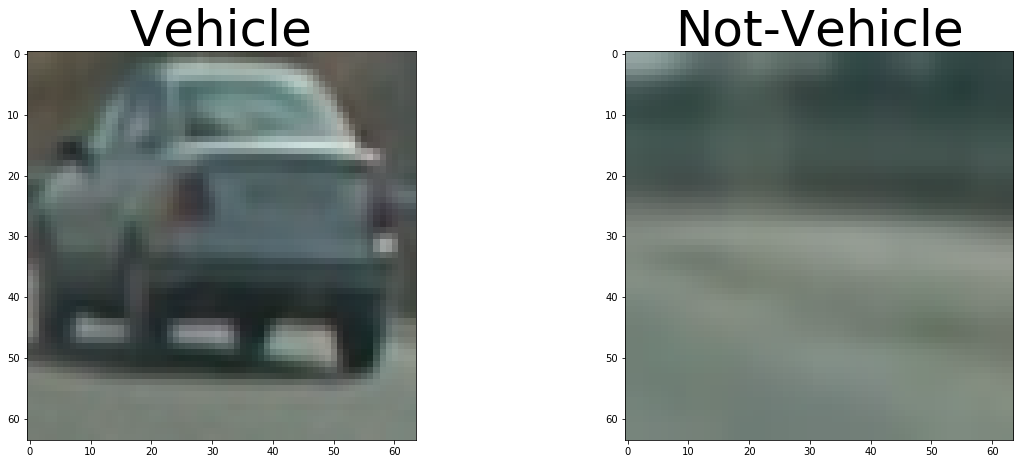

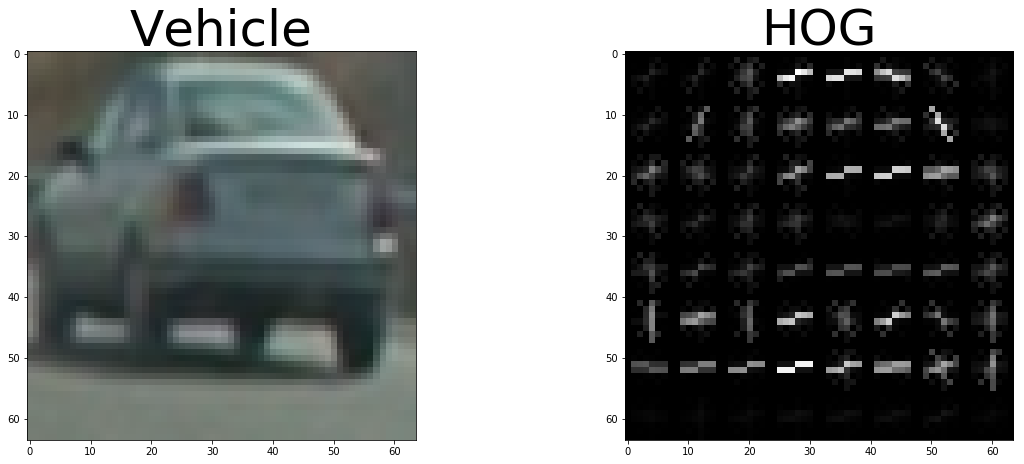

In [26]:
# fetching sample image for distortion
vehicle = mpimg.imread('vehicles/GTI_Right/image0035.png')
non_vehicle = mpimg.imread('non-vehicles/GTI/image11.png')

# showing original and distorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(vehicle)
ax1.set_title('Vehicle', fontsize=50)
ax2.imshow(non_vehicle)
ax2.set_title('Not-Vehicle', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

converted = cv2.cvtColor(vehicle, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(converted, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# showing original and distorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(vehicle)
ax1.set_title('Vehicle', fontsize=50)
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Train classifier

In [27]:
# HOG parameters for extracting features
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size=(32, 32)
hist_bins=32
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_feat=True
hist_feat=True
hog_feat=True

In [28]:
# Divide up into cars and notcars
carImages = glob.glob('vehicles/*/*.png')
notcarImages = glob.glob('non-vehicles/*/*.png')

cars = []
notcars = []
for image in carImages:
    cars.append(image)
for image in notcarImages:
    notcars.append(image)
    
cars = cars[0:500]
notcars = notcars[0:500]

# Extracting car features
car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(len(car_features))
print(len(notcar_features))

500
500


In [32]:
print(car_features[0].shape)

(8460,)


In [29]:
# normalizing data

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
print(X_scaler)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 8460)
(200, 8460)
(800,)
(200,)


In [34]:
# training classifier

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

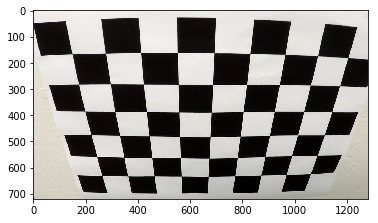

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('camera_cal/calibration2.jpg')
# image shape
IMAGE_SHAPE = (720, 1280, 3)

plt.imshow(img)

## Calibrating camera

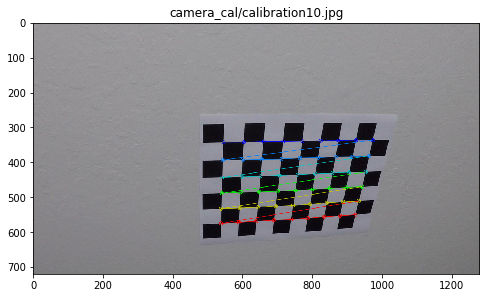

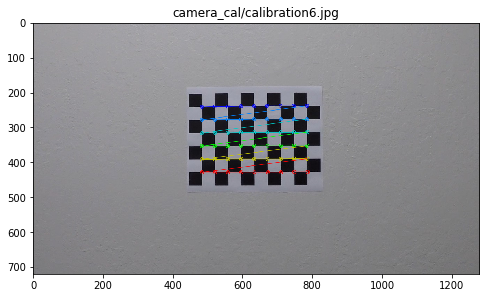

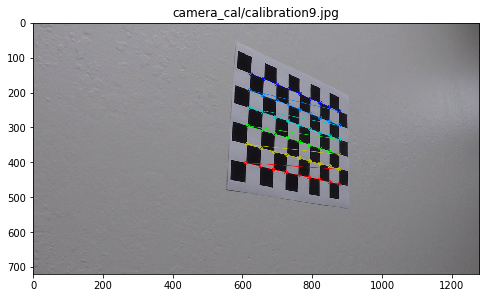

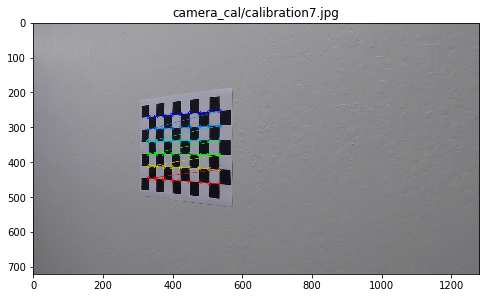

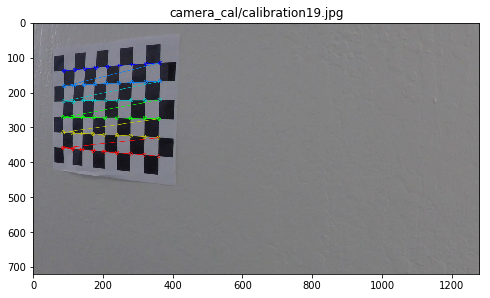

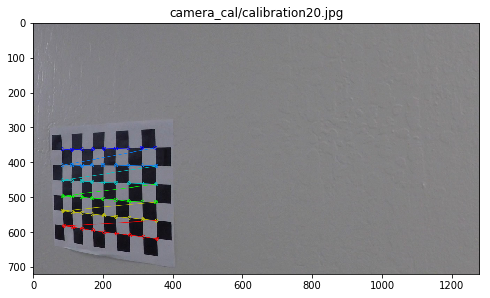

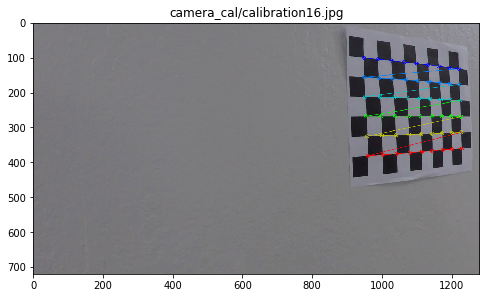

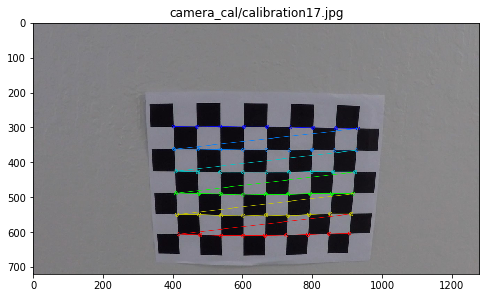

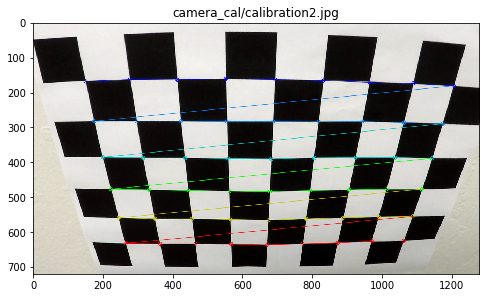

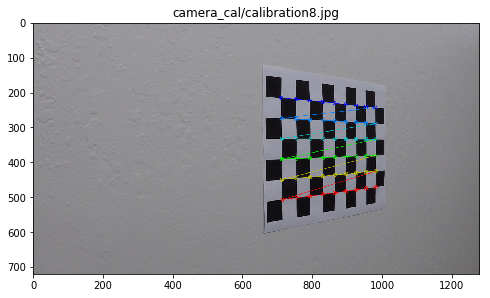

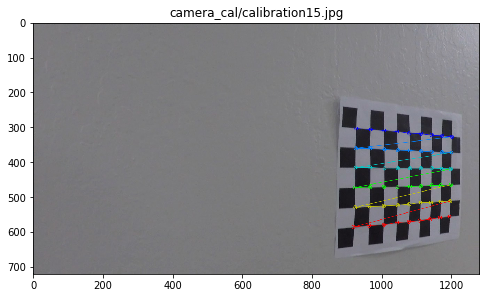

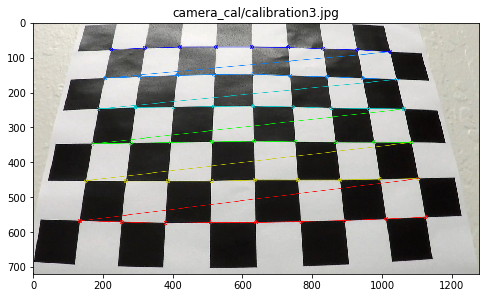

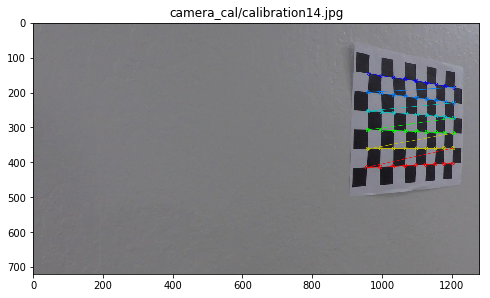

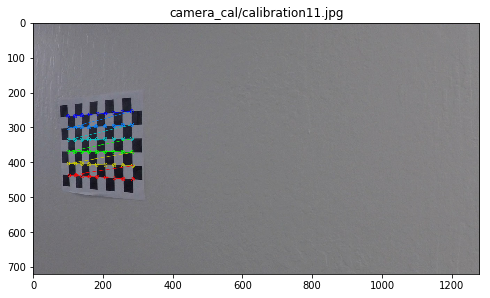

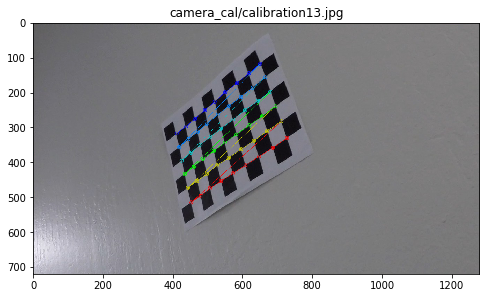

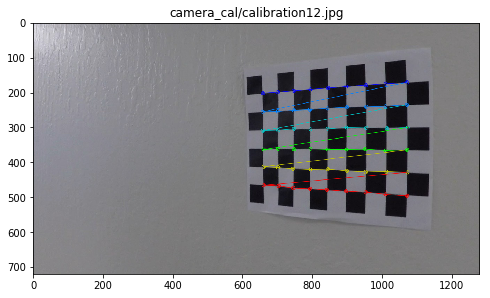

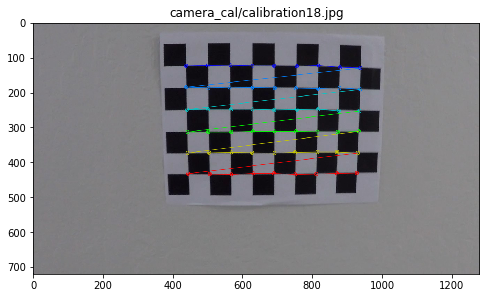

In [2]:
import glob

# chessboard corners counts
nx = 9
ny = 6

images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images

objpoints = [] # 3D points in real world space
imgpoints= [] # 2D points in image plane

# Prepare objects points
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# looping chessboard images
for fname in images:
    #read in each image
    img = mpimg.imread(fname)
    
    # convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # if corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # display corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.figure(figsize=(8,14))
        plt.title(fname)
        plt.imshow(img)

## Original and undistorted images

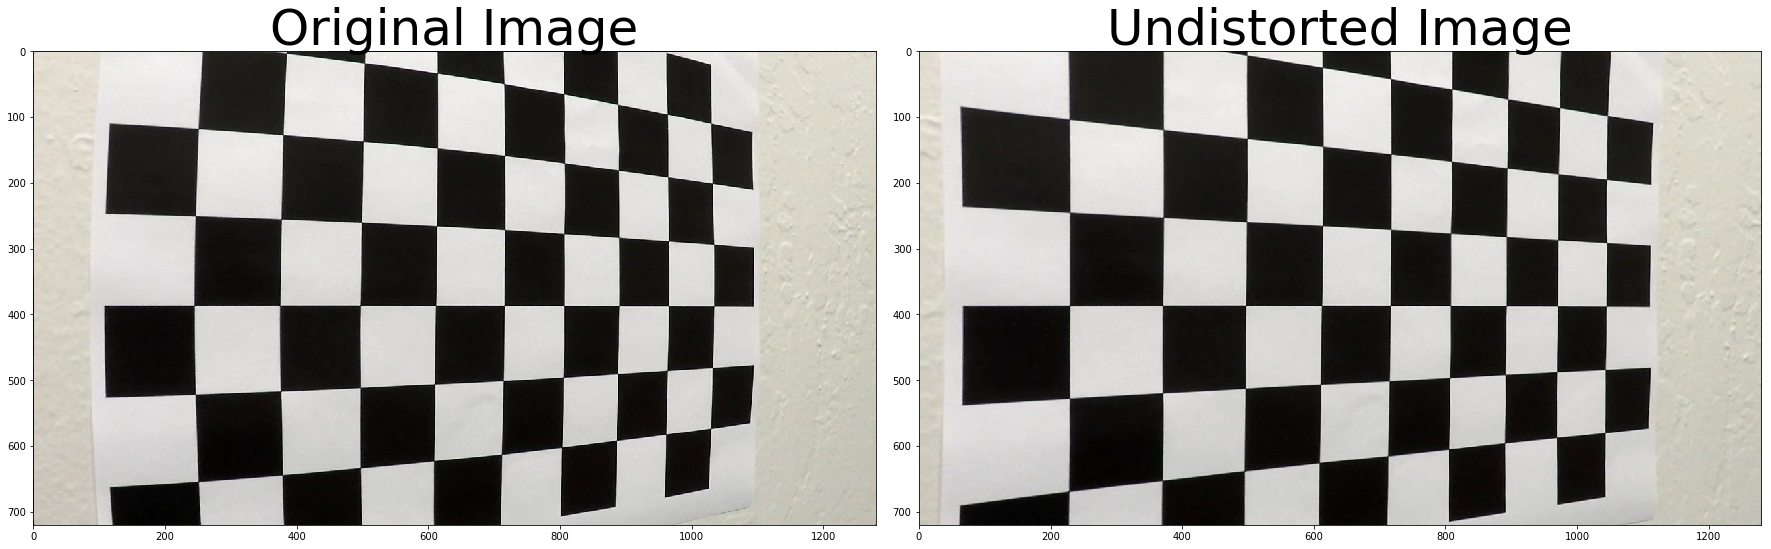

In [3]:
# calibrating camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# fetching sample image for distortion
img_sample = mpimg.imread('camera_cal/calibration5.jpg')

# undistorting
img_undist = cv2.undistort(img_sample, mtx, dist, None, mtx)

# showing original and distorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_sample)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

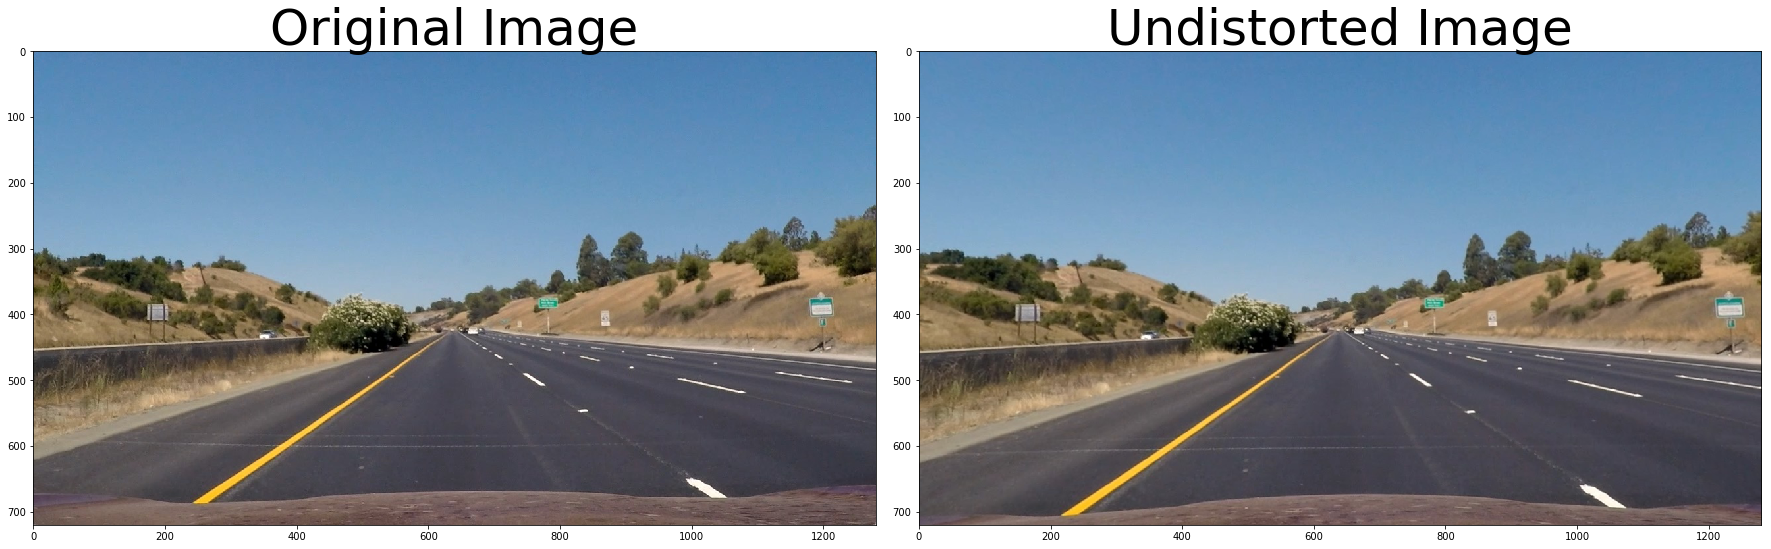

In [4]:
# calibrating camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# fetching sample image for distortion
img_sample = mpimg.imread('test_images/straight_lines1.jpg')

# undistorting
img_undist = cv2.undistort(img_sample, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_sample)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
# show an image
def showImg(img, title=None, figsize=(8,14), map=None):
    plt.figure(figsize=figsize)
    if(title is not None):
        plt.title(fname)
    plt.imshow(img, cmap=map)

### image gradients thresholding functions

In [6]:
def getColorChannel(img, channel='gray'):
    ### returns grayscale of particular color channel of an image
    ### img - rgb image
    
    if(channel=='gray'):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif(channel=='h'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        return hls[:,:,0]
    elif(channel=='l'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        return hls[:,:,1]
    elif(channel=='s'):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        return hls[:,:,2]
    elif(channel=='v'):
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
        return hsv[:,:,2]
    elif(channel=='r'):
        return img[:,:,0]
    elif(channel=='g'):
        return img[:,:,1]
    elif(channel=='b'):
        return img[:,:,2]
    
    return None

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), channel='gray'):
    ### Applying sobel thresholding
    
    # 1) Convert to grayscale
    gray = getColorChannel(img, channel)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), channel='gray'):
    ### Applying thresholding by magnitude of the gradient
    
    # 1) Convert to grayscale
    gray = getColorChannel(img, channel)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(np.power(sobelx,2)+np.power(sobely,2))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_magnitude = np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_magnitude)
    sxbinary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2), channel='gray'):
    ### Applying thresholding by direction of the gradient
    
    # 1) Convert to grayscale
    gray = getColorChannel(img, channel)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sxbinary = np.zeros_like(direction)
    sxbinary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sxbinary

def color_threshold(img, thresh = (0, 255), channel='gray'):    
    ### applying color threshold
    
    # getting grayscale of particular color channel
    gray = getColorChannel(img, channel)
    
    # 2) Apply a threshold to the image
    binary_output = np.zeros_like(gray)
    binary_output[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output


### Binary image

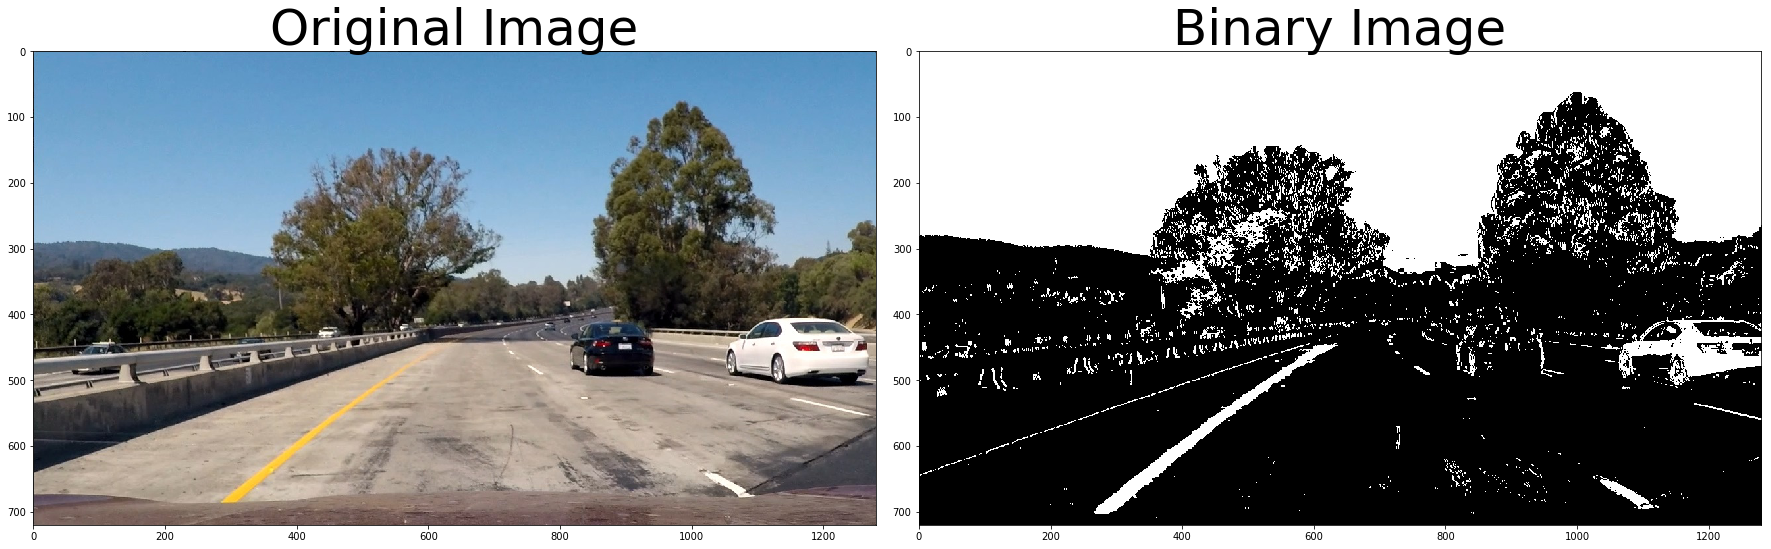

In [7]:
# image thresholding


# fetching sample image for distortion
img_sample = mpimg.imread('test_images/test1.jpg')

# undistorting
initial_image = cv2.undistort(img_sample, mtx, dist, None, mtx)
    
gradx = abs_sobel_thresh(initial_image, orient='x', sobel_kernel=3, thresh=(30, 180), channel='gray')    
color = color_threshold(initial_image, thresh = (60, 255), channel='gray')
color1 = color_threshold(initial_image, thresh = (85, 255), channel='s')    
combined = np.zeros_like(gradx)
combined[(((gradx == 1) | ((color == 1) & (color1 == 1))) )] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_sample)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Classes for storing Lane information

In [8]:
from collections import deque

# Class for storing characteristics of each line
class Line():
    def __init__(self, img_shape):
        # was the line detected in the last iteration?
        self.detected = True     
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None
        #difference in fit coefficients between last and new fits
        self.diffs = None
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # image shape
        self.img_shape = img_shape
        # whether line was corrected
        self.corrected = False

    def process(self, x, y):   
        ### process detected lane points
        
        self.allx = x
        self.ally = y
        
        # calculating the line
        fit = np.polyfit(self.ally, self.allx, 2)
        
        if(not self.current_fit is None):
            # calculating line differencies
            self.diffs = fit - self.current_fit
        
        self.current_fit = fit
        
    def sanityCheck(self):
        ### checking detected lanes
        
        # square root of sums of squares of differences between current line coefficients and average line coefficients
        # the value should be less than 20 (20 was founded sensible for the model)
        diff = math.sqrt(np.sum(np.square(self.diffs)))
        if(not self.diffs is None and diff > 20 ):
            return False
        else:
            return True

# Class for storing characteristics of lane
class Lane():
    def __init__(self, img_shape, N = 3):
        # N instances of left and right line infos to keep in mind
        self.N = N
        
        # image shape
        self.img_shape = img_shape
        
        # was the line detected in the last iteration?
        self.detected = True
        
        # Left line
        self.LeftLine = Line(self.img_shape)
        
        # Right line
        self.RightLine = Line(self.img_shape)
        
        # Left line collections
        self.LeftLines = deque()
        
        # Right line collections
        self.RightLines = deque()
        
        # line center offset
        self.offset = None
        
        # line center offset
        self.offsetDisplay = None
        
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        
        # radius of curvature of the line in some units
        self.radius_of_curvatureDisplay = None
        
        # how many images are processed so far
        self.image_processed = 0
    
    def getAveragedLeftFit(self):
        ### get averaged of last N left lines
        
        leftFit = []
        for item in self.LeftLines:
            # only detected lines matter
            if(item.detected):
                leftFit.append(item.current_fit)
        
        return np.average(leftFit,0)
    
    def getAveragedRightFit(self):
        ### get averaged of last N right lines
        
        rightFit = []
        for item in self.RightLines:
            # only detected lines matter
            if(item.detected):
                rightFit.append(item.current_fit)
        
        return np.average(rightFit,0)
    
    def getAverageRadiusCurvature(self):
        ### get averaged of last N curvature radius
        
        curvature = []
        for left, right in zip(self.LeftLines, self.RightLines):
            # we'll take an average of left and right lines curvatures
            curvature.append((left.radius_of_curvature + right.radius_of_curvature)/2 )
        
        return np.average(curvature,0)
    
    def getCurvatureAndOffset(self, leftx, lefty, rightx, righty):
        ### calculate curvature and offset
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/640 # meters per pixel in x dimension    

        y_eval = self.img_shape[0]-1

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters

        # calculating offset
        # we need left line botoom and right line bottom x coordinates
        left_fit = self.LeftLine.current_fit
        right_fit = self.RightLine.current_fit

        # calculate offset
        leftBase = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        rightBase = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        offsetPixel = (leftBase + rightBase)/2 - (self.img_shape[1])/2

        return left_curverad, right_curverad, offsetPixel*xm_per_pix
    
    def process(self, leftx, lefty, rightx, righty): 
        ### processing detected line pixels
        
        self.detected = True        
        
        # creating last right and left lines
        LeftLine = Line(self.img_shape)
        RightLine = Line(self.img_shape)  
        
        # processing each line
        LeftLine.process(leftx, lefty)
        RightLine.process(rightx, righty)
        
        # appending them to list of line infos
        self.LeftLines.append(LeftLine)
        self.RightLines.append(RightLine)
        
        # if there is more than N items in list
        if(len(self.LeftLines)>self.N):
            self.LeftLines.popleft()
        
        # if there is more than N items in list
        if(len(self.RightLines)>self.N):
            self.RightLines.popleft()
        
        leftFit = self.getAveragedLeftFit()
        rightFit = self.getAveragedRightFit()                
        
        # set averaged lines
        self.LeftLine.current_fit = leftFit
        self.RightLine.current_fit = rightFit
        
        self.LeftLine.allx = LeftLine.allx
        self.LeftLine.ally = LeftLine.ally
        self.RightLine.allx = RightLine.allx
        self.RightLine.ally = RightLine.ally
        
        # calculating diffs between current and averaged lines
        if(not LeftLine.current_fit is None and not self.LeftLine.current_fit is None):
            self.LeftLine.diffs = LeftLine.current_fit - self.LeftLine.current_fit
        if(not RightLine.current_fit is None and not self.RightLine.current_fit is None):
            self.RightLine.diffs = RightLine.current_fit - self.RightLine.current_fit                
        
        # checking the lines
        if(not self.LeftLine.sanityCheck()):
            
            # an average will be without failed line
            LeftLine.detected = False                        
            self.LeftLine.current_fit = self.getAveragedLeftFit()
            LeftLine.current_fit = self.LeftLine.current_fit
            LeftLine.detected = True
            
            # check is failed so the line is corrected
            LeftLine.corrected = True
        else:
            LeftLine.detected = True
            
        # checking the lines
        if(not self.RightLine.sanityCheck()):
            
            # an average will be without failed line
            RightLine.detected = False
            self.RightLine.current_fit = self.getAveragedRightFit()
            RightLine.current_fit = self.RightLine.current_fit
            RightLine.detected = True
            
            # check is failed so the line is corrected
            RightLine.corrected = True
        else:
            RightLine.detected = True                       
        
        # curvateure and offset
        left_curverad, right_curverad, offset = self.getCurvatureAndOffset(leftx, lefty, rightx, righty)
        LeftLine.radius_of_curvature = left_curverad
        RightLine.radius_of_curvature = right_curverad
        self.offset = offset
        self.radius_of_curvature = self.getAverageRadiusCurvature()
        
        # we gonna display only every N-th curavature and offset so it changes more smoothly on image
        if(self.image_processed%self.N == 0):
            if(self.radius_of_curvatureDisplay is None):
                self.radius_of_curvatureDisplay = self.radius_of_curvature
            else:
                self.radius_of_curvatureDisplay = (self.radius_of_curvatureDisplay+self.radius_of_curvature)/2
            self.offsetDisplay = self.offset
            
        # one more image have been processed
        self.image_processed += 1

LaneInfo = Lane(IMAGE_SHAPE)

### perspective transformation

In [9]:
# setting points for perspective transformation
leftBtX = 203
leftBtY = 720
leftTpX = 580
leftTpY = 460
rightTpX = 705 
rightTpY = 460
rightBtX = 1127
rightBtY = 720

leftBtXTr = 320
leftBtYTr = 720
leftTpXTr = 320 
leftTpYTr = 0
rightTpXTr = 960 
rightTpYTr = 0
rightBtXTr = 960 
rightBtYTr = 720

src = np.float32(
        [[leftBtX,leftBtY],
         [leftTpX,leftTpY],
         [rightTpX,rightTpY],
         [rightBtX,rightBtY]])
    
dst = np.float32(
        [[leftBtXTr,leftBtYTr],
         [leftTpXTr,leftTpYTr],
         [rightTpXTr,rightTpYTr],
         [rightBtXTr,rightBtYTr]])

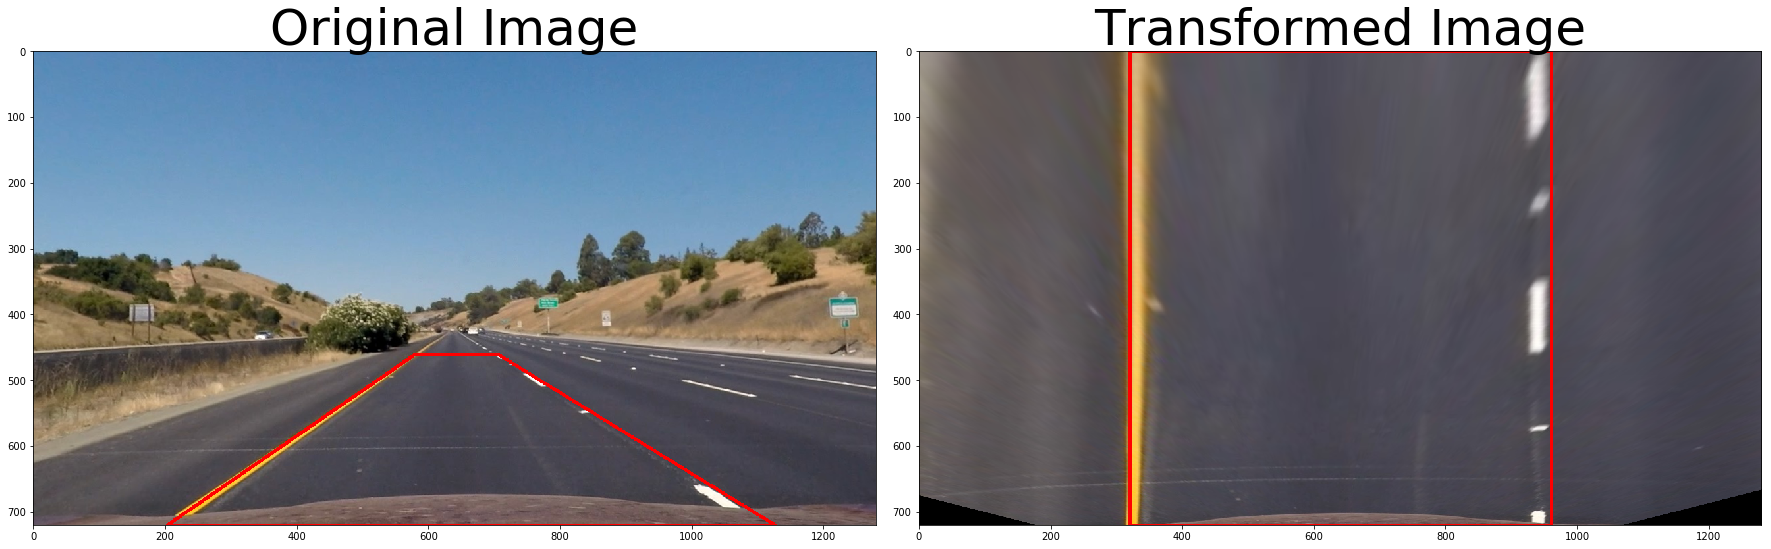

In [10]:
def drawPerspectiveLines(img, color=[255, 0, 0], thickness=3):
    ### draw lines between points for perspective transform
    cv2.line(img, (leftBtX, leftBtY),(leftTpX, leftTpY), color, thickness)
    cv2.line(img, (leftTpX, leftTpY),(rightTpX, rightTpY), color, thickness)
    cv2.line(img, (rightTpX, rightTpY),(rightBtX, rightBtY), color, thickness)
    cv2.line(img, (rightBtX, rightBtY),(leftBtX, leftBtY), color, thickness)
    
def drawPerspectiveLinesWarped(img, color=[255, 0, 0], thickness=3):
    ### draw lines between points for perspective transform
    cv2.line(img, (leftBtXTr, leftBtYTr),(leftTpXTr, leftTpYTr), color, thickness)
    cv2.line(img, (leftTpXTr, leftTpYTr),(rightTpXTr, rightTpYTr), color, thickness)
    cv2.line(img, (rightTpXTr, rightTpYTr),(rightBtXTr, rightBtYTr), color, thickness)
    cv2.line(img, (rightBtXTr, rightBtYTr),(leftBtXTr, leftBtYTr), color, thickness)
    
def transPerspective(img):
    ### apply perspective transform
    # get image size
    img_size = (img.shape[1],img.shape[0])
    
    # compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def transPerspectiveBack(warped, img_size):
    ### apply perspective transform back        
    
    # compute perspective transform
    M = cv2.getPerspectiveTransform(dst, src)
    
    # create warped image
    img = cv2.warpPerspective(warped, M, img_size, flags=cv2.INTER_LINEAR)
    return img
    
# transformation example
straitLineImg1 = mpimg.imread('test_images/straight_lines1.jpg')
straitLineImg1 = cv2.undistort(straitLineImg1, mtx, dist, None, mtx)

straitLineImgPersp_1 = transPerspective(cv2.undistort(straitLineImg1, mtx, dist, None, mtx))

drawPerspectiveLinesWarped(straitLineImgPersp_1)
drawPerspectiveLines(straitLineImg1)

#show images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(straitLineImg1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(straitLineImgPersp_1)
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
def getDetectedLaneImages(warped_image):
    ### finding lane line images on warped image
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, LaneInfo.img_shape[0]-1, LaneInfo.img_shape[0] )
    left_fitx = LaneInfo.LeftLine.current_fit[0]*ploty**2 + LaneInfo.LeftLine.current_fit[1]*ploty + LaneInfo.LeftLine.current_fit[2]
    right_fitx = LaneInfo.RightLine.current_fit[0]*ploty**2 + LaneInfo.RightLine.current_fit[1]*ploty + LaneInfo.RightLine.current_fit[2]
    
    # filling detected lane so it will be green
    lanePolyLeft = np.dstack((left_fitx, ploty))
    lanePolyRight = np.dstack((right_fitx, ploty))
    lanePoly = np.concatenate((lanePolyLeft, lanePolyRight[:,::-1,:]), axis = 1)    
    lane_img = np.zeros(LaneInfo.img_shape, dtype=np.uint8)
    cv2.fillPoly(lane_img, np.int_([lanePoly]), (0,255, 0))
        
    # this will be the little warped image on the right top part of the big one
    poly_img = np.zeros(LaneInfo.img_shape, dtype=np.uint8)
    cv2.fillPoly(poly_img, np.int_([lanePoly]), (0,255, 0))    
    poly_img = cv2.addWeighted(np.dstack((warped_image, warped_image, warped_image))*255, 1, poly_img, 0.3, 0)
    poly_img[LaneInfo.LeftLine.ally, LaneInfo.LeftLine.allx] = [255, 255, 255]
    poly_img[LaneInfo.RightLine.ally, LaneInfo.RightLine.allx] = [255, 255, 255]
    
    cv2.polylines(poly_img, [np.asarray(lanePolyLeft.reshape((-1,1,2)), dtype=np.int32),
                             np.asarray(lanePolyRight.reshape((-1,1,2)), dtype=np.int32),
                            ], False, (255,0,0), 5)
    
    # drawing detected left and right points
    left_line_img = np.zeros(LaneInfo.img_shape, dtype=np.uint8)
    right_line_img = np.zeros(LaneInfo.img_shape, dtype=np.uint8)
    left_line_img[LaneInfo.LeftLine.ally, LaneInfo.LeftLine.allx] = [255, 0, 0]
    right_line_img[LaneInfo.RightLine.ally, LaneInfo.RightLine.allx] = [0, 0, 255]
    
    # uwarp detected points and lane
    img_size = (LaneInfo.img_shape[1], LaneInfo.img_shape[0])
    
    left_line_img = transPerspectiveBack(left_line_img, img_size)
    right_line_img = transPerspectiveBack(right_line_img, img_size)
    lane_img = transPerspectiveBack(lane_img, img_size)
    
    # left line pixels image,  right line pixels image, Lane filled image, warped image
    return left_line_img, right_line_img, lane_img, poly_img

## Pipeline

In [12]:
def detectLane(binary_warped):
    ### detecting line pixels from warped image
    global LaneInfo
    
    leftx_base = None
    rightx_base = None
    
    # whether all left lines was corrected
    if(len(LaneInfo.LeftLines) > 0 and (all([lines.corrected for lines in LaneInfo.LeftLines]) 
           or all([lines.corrected for lines in LaneInfo.RightLines]))):
        
        # this case when last N lines are all corrected
        leftCurFit = LaneInfo.LeftLine.current_fit
        rightCurFit = LaneInfo.RightLine.current_fit
        
        # in that case we should start searching lines from the beginning
        y_eval = LaneInfo.img_shape[0]-1       
        
        # However, the base for line we'll take from the previous lines
        leftx_base = leftCurFit[0]*y_eval**2 + leftCurFit[1]*y_eval + leftCurFit[2]
        rightx_base = rightCurFit[0]*y_eval**2 + rightCurFit[1]*y_eval + rightCurFit[2]
        
        LaneInfo = Lane(IMAGE_SHAPE)
    
    if((LaneInfo.LeftLine.current_fit is None) or (LaneInfo.RightLine.current_fit is None)):            
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        
        if(leftx_base is None and rightx_base is None):
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 50
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    
    else:
        ################################################################################
                
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels        
        
        left_fit = LaneInfo.LeftLine.current_fit
        right_fit = LaneInfo.RightLine.current_fit
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # line pixels should be in the vicinity of the previous found lane line
        margin = 50
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))          
    
    ###### Updating left and right lines information
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]        
    
    LaneInfo.process(leftx, lefty, rightx, righty)

In [13]:
import math

def pipeline(initial_image, fileName=None):
    ### pipeline that exposes lane on image    
    
    # undistorting the image
    initial_image = cv2.undistort(initial_image, mtx, dist, None, mtx)
    
    # x gradient
    gradx = abs_sobel_thresh(initial_image, orient='x', sobel_kernel=3, thresh=(30, 180), channel='gray')    
    # color threshold for grayscale
    color = color_threshold(initial_image, thresh = (60, 255), channel='gray')
    # color threshold for s channel
    color1 = color_threshold(initial_image, thresh = (85, 255), channel='s')
    
    combined = np.zeros_like(gradx)
    # combined threshold
    combined[(((gradx == 1) | ((color == 1) & (color1 == 1))) )] = 1
    
    # perspective transformation
    combined = transPerspective(combined)    
    
    # finding lane line on warped image
    detectLane(combined)    
    left_line_img, right_line_img, window_img, poly_img = getDetectedLaneImages(combined)    

    # add detected point and lane to the original image
    result = cv2.addWeighted(initial_image, 1, left_line_img, 2, 0)
    result = cv2.addWeighted(result, 1, right_line_img, 2, 0)
    result = cv2.addWeighted(result, 1, window_img, 0.3, 0)   
    
    # add curvateure and offset to the image    
    cv2.putText(result, "curvature = {:.0f} m".format(LaneInfo.radius_of_curvatureDisplay), (50, 50), cv2.FONT_HERSHEY_TRIPLEX, 1, (0,0,0), 1)
    if(LaneInfo.offsetDisplay > 0):
        offsetOrientation = 'left'
    else:
        offsetOrientation = 'right'
    cv2.putText(result, "offset = {:.2f} m {}".format(abs(LaneInfo.offsetDisplay), offsetOrientation), (50, 100), cv2.FONT_HERSHEY_TRIPLEX, 1, (0,0,0), 1)                
        
    # put small warped image to the big one
    smallImgShape = (int(IMAGE_SHAPE[0]/3), int(IMAGE_SHAPE[1]/3))
    poly_img = cv2.resize(poly_img, (smallImgShape[1], smallImgShape[0]))
    
    result[50:50+smallImgShape[0], 804:804+smallImgShape[1]] = poly_img
    
    return result

def process_image(image):
    ### image process function for video
    
    result = pipeline(image)
    
    # converting to 3 channel image for video
    if(len(result.shape) == 2):
        result = result[:,:,None]
        result = np.uint8(result*[1,1,1])
        result = np.uint8(255*result/np.max(result))        

    return result;

In [14]:
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def processVideo(videoFile, videoFileOut=None):
    ### video of processed image
    
    videoIn = videoFile    
    
    if(videoFileOut is None):
        name, ext = os.path.splitext(videoIn)
        videoOut = name + '_out' + ext
    else:
        videoOut = videoFileOut
    
    clip = VideoFileClip(videoIn)
    clipProcessed = clip.fl_image(process_image)
    clipProcessed.write_videofile(videoOut, audio=False)
    return videoOut

### An example of image

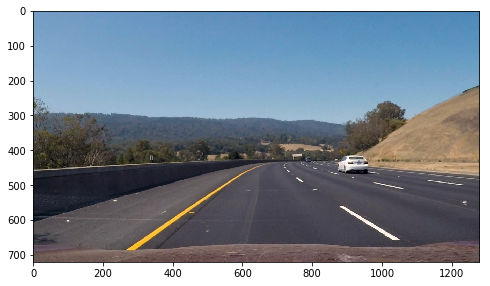

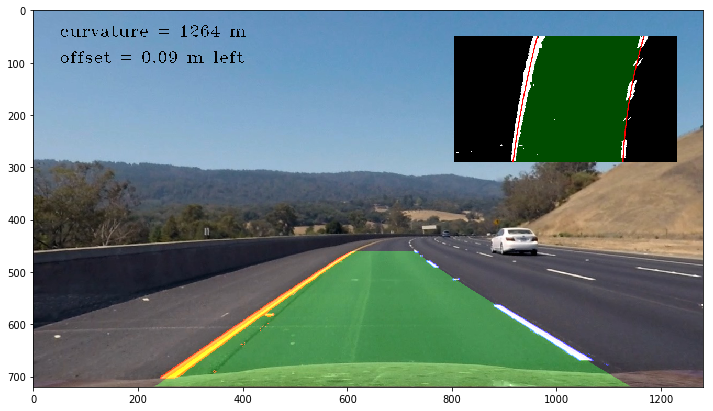

In [15]:
LaneInfo = Lane(IMAGE_SHAPE)
sampleImgFile = 'test_images/test3.jpg'

img = mpimg.imread(sampleImgFile)
showImg(img)

img1 = pipeline(img)
showImg(img1, figsize=(12,21), map='gray')

### An example of video

In [16]:
# resetting the lane info
LaneInfo = Lane(IMAGE_SHAPE)

videoFileName = 'project_video.mp4'
ouputVideo = processVideo('project_video.mp4')

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:39<00:00,  5.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(ouputVideo))